<a id='dataset'></a>

# Checking out the performance of patched `get_point_cloud`

We perform two tests:
* The first one involves assembling large part of one of the horizons from labels for `P_cube` using standard prediction-pipeline and profiling.
* `get_point_cloud` is based on function `check_if_joinable`. That said, we also theck the performance of `check_if_joinable` by generating a second bordering horizon-part.

The same tests are to be conducted later on new horizon-format.

In [ ]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import logging
import json
from copy import copy

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import trange, tqdm

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex, action, inbatch_parallel
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset
from seismiqb import FILL_VALUE, convert_to_numba_dict, mask_to_horizon
from seismiqb import plot_loss, check_if_joinable

In [4]:
from seismiqb import compare_horizons

# Preparations: `Dataset` for `P_cube` and `horizon-labels`

In [5]:
paths_cubes = ['/notebooks/data/seismic/CUBE_3/P_cube.hdf5']
dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi, batch_class=SeismicCropBatch)

In [6]:
%%time
ds = ds.load(horizon_dir='/BEST_HORIZONS/*')

CPU times: user 15.6 s, sys: 2.83 s, total: 18.5 s
Wall time: 18.5 s


In [7]:
len(ds.labels['P_cube'])

3898501

In [8]:
# Global constants
EPOCHS = 450
NUM_CROPS = 64
CROP_SHAPE = (1, 256, 512) # i, x, h

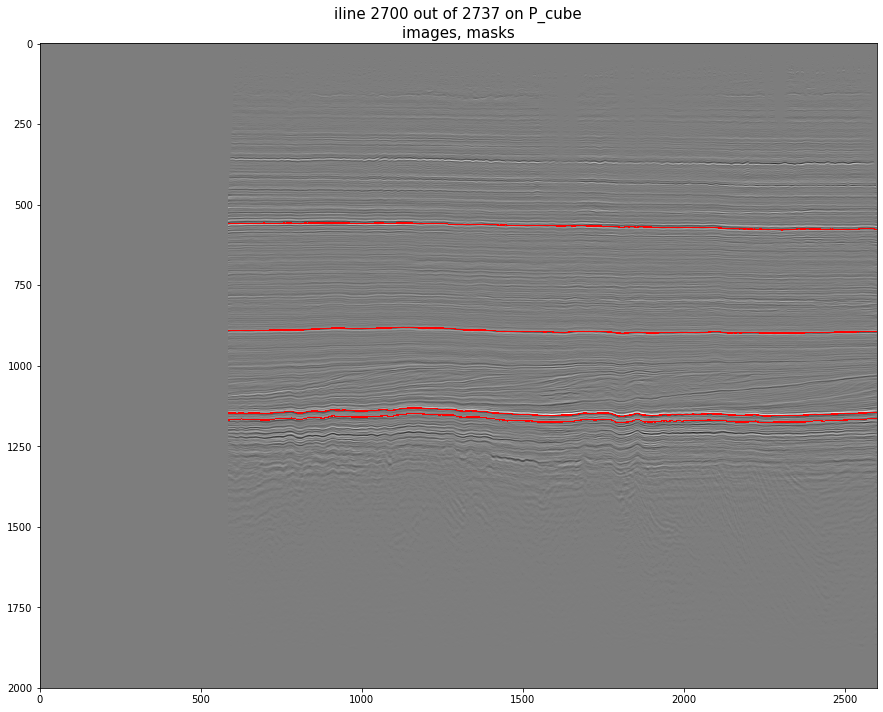

In [9]:
ds.show_slide(n_line=2700)

In [10]:
# Pipeline template. Can be used multiple times (for different datasets)
val_template = (Pipeline()
                # Init variables for storing masks and point clouds
                .init_variable('separate_masks', [])
                .init_variable('result_point_clouds', [])
                # Load data
                .load_component(src=D('geometries'), dst='geometries')
                .crop(points=D('grid_gen')(), shape=CROP_SHAPE)
                .load_cubes(dst='images')
                .create_masks(dst='masks', width=1)
                .rotate_axes(src='masks')
                .update(V('separate_masks', mode='e'), B('masks'))
                .get_point_cloud(dst=V('result_point_clouds'), coordinates='lines',
                                 src_masks='masks')
                .assemble_crops(src=V('separate_masks'), dst='assembled_pred',
                                grid_info=D('grid_info')))

# Test 1: Making predictions on large horizon-part along with profiling

* make prediction on large crop

In [17]:
ds.geometries['P_cube']

Inferred geometry for P_cube.hdf5: (2737x2599x2001)

In [20]:
ds.make_grid('P_cube', CROP_SHAPE, [2670, 2700], [1000, 1700], [0, 2000],
             strides=(1, 200, 400),
             batch_size=24)

In [21]:
from tqdm import tqdm_notebook
val_pipeline = val_template << ds
for _ in tqdm_notebook(range(ds.grid_iters)):
    batch = val_pipeline.next_batch(D('size'), n_epochs=None, profile=True)

In [22]:
val_pipeline.show_profile_info(per_iter=False, detailed=False)

total_time                     pipeline_time            \
                          sum      mean       max           sum      mean   
action                                                                      
get_point_cloud #6   8.457624  0.338305  0.607538      8.328010  0.333120   
load_cubes #2        7.262542  0.290502  0.320176      7.033175  0.281327   
create_masks #3      1.698403  0.067936  0.073019      1.512429  0.060497   
assemble_crops #7    0.792610  0.031704  0.671378      0.688223  0.027529   
rotate_axes #4       0.402303  0.016092  0.021335      0.298187  0.011927   
crop #1              0.143538  0.005742  0.007186      0.043544  0.001742   
load_component #0    0.087220  0.003489  0.004145      0.001157  0.000046   
update #5            0.078550  0.003142  0.004263      0.002379  0.000095   

                              
                         max  
action                        
get_point_cloud #6  0.602534  
load_cubes #2       0.311078  
create_masks #3     0.065598  
assemble_crops #7   0.667218  
rotate_axes #4      0.014580  
crop #1             0.002274  
load_component #0   0.000066  
update #5           0.000126

In [23]:
len(val_pipeline.get_variable('result_point_clouds'))

4

* check out the lengths of resulting horizons

In [24]:
for hor in val_pipeline.get_variable('result_point_clouds'):
    print(len(hor))

25680
25680
25680
25680


# Test 2: Generating bordering horizon-part and timing `check_if_joinable`

In [25]:
ds.make_grid('P_cube', CROP_SHAPE, [2640, 2670], [1300, 2000], [0, 2000],
             strides=(1, 200, 400),
             batch_size=24)

In [26]:
from tqdm import tqdm_notebook
val_pipeline_2 = val_template << ds
for _ in tqdm_notebook(range(ds.grid_iters)):
    batch = val_pipeline_2.next_batch(D('size'), n_epochs=None)

In [27]:
len(val_pipeline_2.get_variable('result_point_clouds'))

11

In [29]:
for hor in val_pipeline_2.get_variable('result_point_clouds'):
    print(len(hor))

25662
25680
25680
25678
1
1
1
1
4
1
11


In [35]:
%%timeit
check_if_joinable(val_pipeline_2.get_variable('result_point_clouds')[0], val_pipeline.get_variable('result_point_clouds')[0])

31.9 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
